# CARTO frames workshop

Full details at the [documentation](https://cartodb.github.io/cartoframes/) page. I'm using the `master` branch installed using

```sh
pip install cartoframes jupyter seaborn
```


In [1]:
import cartoframes
from cartoframes import Credentials, CartoContext
import pandas as pd
import os

## Load the credentials

In [2]:
try:
    cc = cartoframes.CartoContext()
    print('Getting the credentials from a previous session')
except Exception as e:
    print('Getting the credentials from your environment or here')
    BASEURL = os.environ.get('CARTO_API_URL','https://jsanz.carto.com') # <-- replace with your username or set up the envvar
    APIKEY = os.environ.get('CARTO_API_KEY',False) # <-- replace False with your CARTO API key or set up the envvar
    if BASEURL and APIKEY:
        creds = Credentials(base_url=BASEURL,key=APIKEY)
        creds.save()
        cc = cartoframes.CartoContext()
    else:
        print('Set up your environment!')
    

Getting the credentials from a previous session


## Load the typical `Populated Places` dataset from CARTO

You can import this dataset from the Data Library

In [3]:
df = cc.read('populated_places')
df.head()

,_feature_count,adm0_a3,adm0cap,adm0name,adm1name,admin1_cod,capalt,capin,changed,checkme,...,scalerank,sov0name,sov_a3,the_geom,timezone,un_adm0,un_fid,un_lat,un_long,worldcity
cartodb_id,,,,,,,,,,,,,,,,,,,,,
2338,1,ZWE,0,Zimbabwe,Midlands,0,0,None,0,0,...,7,Zimbabwe,ZWE,0101000020E61000009083EF6FCBCC3D401F917ACCFAED...,Africa/Harare,None,0,0.0,0.0,0
2339,1,ZWE,0,Zimbabwe,Matabeleland South,0,0,None,4,0,...,7,Zimbabwe,ZWE,0101000020E6100000B058CD4DEBD13B40A07C9217C37A...,Africa/Harare,None,0,0.0,0.0,0
2340,1,ZWE,0,Zimbabwe,Matabeleland South,0,0,None,0,0,...,7,Zimbabwe,ZWE,0101000020E6100000B0B0E83570FD3D40A0872F4EA935...,Africa/Harare,None,0,0.0,0.0,0
2341,1,ZWE,0,Zimbabwe,Matabeleland South,7,0,None,0,0,...,7,Zimbabwe,ZWE,0101000020E61000007F20C3768F023D409096DD958AF0...,Africa/Harare,None,0,0.0,0.0,0
2342,1,ZWE,0,Zimbabwe,Masvingo,0,0,None,0,0,...,7,Zimbabwe,ZWE,0101000020E6100000A106041EF7A83F4030047E69B10C...,Africa/Harare,None,0,0.0,0.0,0


## It's a Pandas data frame

You can get the `featurecla` field counts

In [4]:
df.groupby('featurecla').featurecla.count()

featurecla
Admin-0 capital            202
Admin-0 capital alt         13
Admin-0 region capital      28
Admin-1 capital           2057
Admin-1 region capital      71
Historic place               6
Meteorological Station       1
Populated place           4925
Scientific station          40
Name: featurecla, dtype: int64

## Run SQL queries

In [5]:
cc.query('''
SELECT featurecla,count(*) as counts
FROM populated_places
GROUP BY featurecla
''')

,counts,featurecla
0,1,Meteorological Station
1,28,Admin-0 region capital
2,4925,Populated place
3,2057,Admin-1 capital
4,202,Admin-0 capital
5,71,Admin-1 region capital
6,6,Historic place
7,13,Admin-0 capital alt
8,40,Scientific station


## Draw graphics using Seaborn

More about seaborn [here](https://seaborn.pydata.org/)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

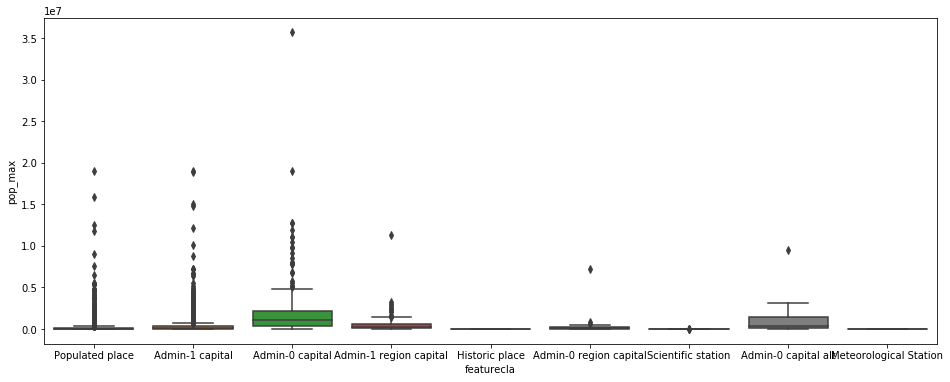

In [22]:
f, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(x="featurecla", y="pop_max", data=df);

## Render your tables from CARTO

In [21]:
from cartoframes import Layer, styling
l = Layer(
    'populated_places', 
    color={'column': 'featurecla','scheme': styling.prism(9)},
    size ={'column': 'pop_max','bin_method':'quantiles','bins' : 4, 'min': 3, 'max':10}
)
cc.map(layers=l, interactive=True)

## Render queries from CARTO

In [26]:
from cartoframes import QueryLayer
lines = QueryLayer(
    '''
    WITH capitals as (
      select * 
        from populated_places 
       where featurecla like 'Admin-0 capital'
    )
    select pp.cartodb_id,
           pp.pop_max,
           ST_MakeLine(c.the_geom,pp.the_geom) as the_geom,
           ST_MakeLine(c.the_geom_webmercator,pp.the_geom_webmercator) as the_geom_webmercator
    from populated_places pp join capitals c on pp.adm0_a3 = c.adm0_a3
    where c.adm0_a3 = 'ESP'
    ''', 
    color = {'column':'pop_max','scheme':styling.sunset(bins=3)},
    size ={'column': 'pop_max','bin_method':'quantiles','bins' : 4, 'min': 3, 'max':10}
)
cc.map(layers=lines, interactive=True,zoom=4, lat=36.19, lng=-6.79)

In [28]:
points = QueryLayer(
    '''
    select *
    from populated_places
    where adm0_a3 = 'ESP'
    ''', 
    color = {'column':'pop_max','scheme':styling.sunset(bins=3)},
    size =  {'column':'pop_max','bin_method':'quantiles','bins' : 4, 'min': 3, 'max':7}
)
cc.map(layers=[lines,points], interactive=True,zoom=4, lat=36.19, lng=-6.79)

## Crazy queries

You can render fancy queries, more details [here](https://gist.github.com/jsanz/8aeb48a274e3b787ca57)

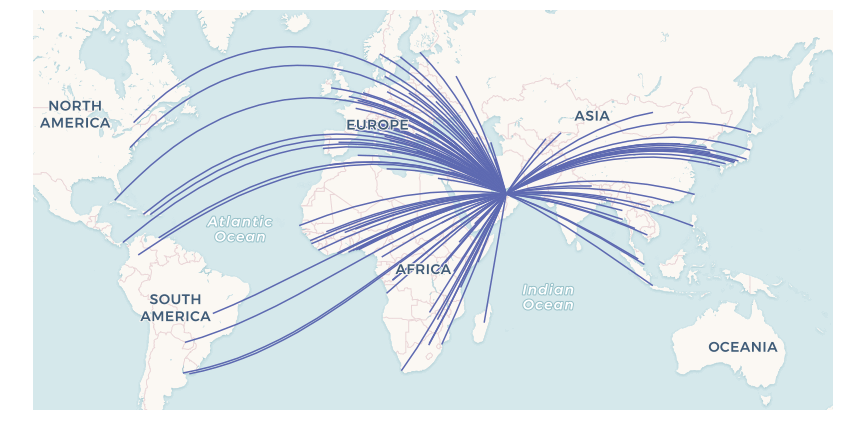

In [11]:
query = '''
with -- first data
data as (
  SELECT * 
  FROM jsanz.ne_10m_populated_places_simple_7 
  WHERE 
(megacity >= 0.5 AND megacity <= 1)  AND featurecla IN ('Admin-0 capital','Admin-1 region capital','Admin-0 region capital','Admin-0 capital alt')
), -- from dubai
origin as (
  select *
  from jsanz.ne_10m_populated_places_simple_7
  where cartodb_id = 7263
), -- cities closer to 14000 Km
dests as (
  select d.*,
  ST_Distance(
    o.the_geom::geography,
    d.the_geom::geography
  )::int distance
  from data d, origin o
  where 
    ST_DWithin( o.the_geom::geography, d.the_geom::geography, 14000000 ) 
),
geoms as (
    select 
    dests.cartodb_id,  dests.name, dests.adm0name, dests.distance,
    st_transform(
      st_segmentize(
        st_makeline(
          origin.the_geom,
          dests.the_geom
        )::geography,
        10000
       )::geometry,
      3857) the_geom_webmercator
    from origin,dests
)
select *, st_transform(the_geom_webmercator,4326) as the_geom from geoms
'''
cc.map(QueryLayer(query), interactive=False, zoom=2, lat=19.9, lng=29.5)

## Create a new table on CARTO

In [12]:
df_spain = df[(df['adm0_a3'] == 'ESP')]
df_spain['name'].head()

cartodb_id
2361                     Lorca
2362                 Cartagena
2363                    Oviedo
2364    Santiago de Compostela
2365                   Badajoz
Name: name, dtype: object

In [13]:
cc.write(df_spain, 'places_spain', overwrite=True)

Table successfully written to CARTO: https://jsanz.carto.com/dataset/places_spain


In [14]:
cc.query('SELECT DISTINCT adm0_a3 FROM places_spain')

,adm0_a3
0,ESP


## Modify schema and data

Drop a column

In [15]:
df_spain = df[(df['adm0_a3'] == 'ESP')]
df_spain = df_spain.drop('adm0_a3', 1)
cc.write(df_spain, 'places_spain', overwrite=True)

Table successfully written to CARTO: https://jsanz.carto.com/dataset/places_spain


In [16]:
try:
    cc.query('SELECT DISTINCT adm0_a3 FROM places_spain')
except Exception as e:
    print(e)

['column "adm0_a3" does not exist']


Add `València` as an alternate name for the city of `Valencia`

In [17]:
vlc_id =  df_spain[df.apply(lambda x: x['name'] == 'Valencia', axis=1)].index.values[0]
df_spain = df_spain.set_value(vlc_id,'cityalt','València')

In [18]:
# THE FUTURE
# cc.sync(df_spain,'places_spain')

# THE PRESENT
cc.write(df_spain, 'places_spain', overwrite=True)

Table successfully written to CARTO: https://jsanz.carto.com/dataset/places_spain


In [19]:
cc.query('''SELECT name,cityalt from places_spain WHERE cartodb_id = {}'''.format(vlc_id))

,cityalt,name
0,València,Valencia


## Delete the table

In [20]:
cc.delete('places_spain')

## But there's more

Take a look into the documentation for other functions related with CARTO Data Observatory. All these features are is still under active development, things may change quickly.